In [4]:
import pandas as pd, tensorflow as tf, matplotlib.pyplot as plt, numpy as np, os, datetime
import networkx as nx, pydot, graphviz, plotly.io as pio, plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import plot_model
from keras.models import load_model
from torch.utils.tensorboard import SummaryWriter
from math import sqrt

In [2]:
#Data Base Import
db=pd.read_excel(r'D:\ToolBox\.py\rep_1\data\processed\db_2.0.xlsx')

#Data Extraction
y1 = db ["As_opt"]
y2 = db ["d_opt"]
y3 = db ["As_opt_p"]
x  = db [["fc","fy","Mu","b"]]

#RMSE def
def rmse(ytrue,ypred):
  return tf.sqrt(tf.reduce_mean(tf.square(ytrue - ypred)))

In [3]:
#Split: DataBase into: Training and Testing Data
xtrain,xtest,ytrain1,ytest1,ytrain2,ytest2,ytrain3,ytest3 = train_test_split(x,y1,y2,y3,test_size=0.2,random_state=1) 

In [9]:
# Auto-Saving Model Training: Callback ModelCheckpoint
checkpoint = ModelCheckpoint(r'D:\ToolBox\.py\rep_1\models\mdl_checkpoint_bms_1.0.keras', monitor='val_loss', save_best_only=True)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,write_graph=True)

In [10]:
# Model: Arquitecture
n1= 40; n2= 40; n3= 40; n4= 40; total_neurons = n1+ n2+ n3+ n4; total_layers = 4

input_layer = tf.keras.layers.Input(shape=(xtrain.shape[1],), name="Input Layer: fc, fy, Mu, b")
hidden_layer = tf.keras.layers.Dense(n1, activation="relu", name="Densa_1")(input_layer)
hidden_layer = tf.keras.layers.Dense(n2, activation="relu", name="Densa_2")(hidden_layer)
hidden_layer = tf.keras.layers.Dense(n3, activation="relu", name="Densa_3")(hidden_layer)
hidden_layer = tf.keras.layers.Dense(n4, activation="relu", name="Densa_4")(hidden_layer)

output1 = tf.keras.layers.Dense(1, name="As_opt")(hidden_layer)  # Primera salida
output2 = tf.keras.layers.Dense(1, name="d_opt")(hidden_layer)  # Segunda salida
output3 = tf.keras.layers.Dense(1, name="As_opt_p")(hidden_layer)  # Tercera salida

mdl = tf.keras.Model(inputs=input_layer, outputs=[output1, output2, output3])

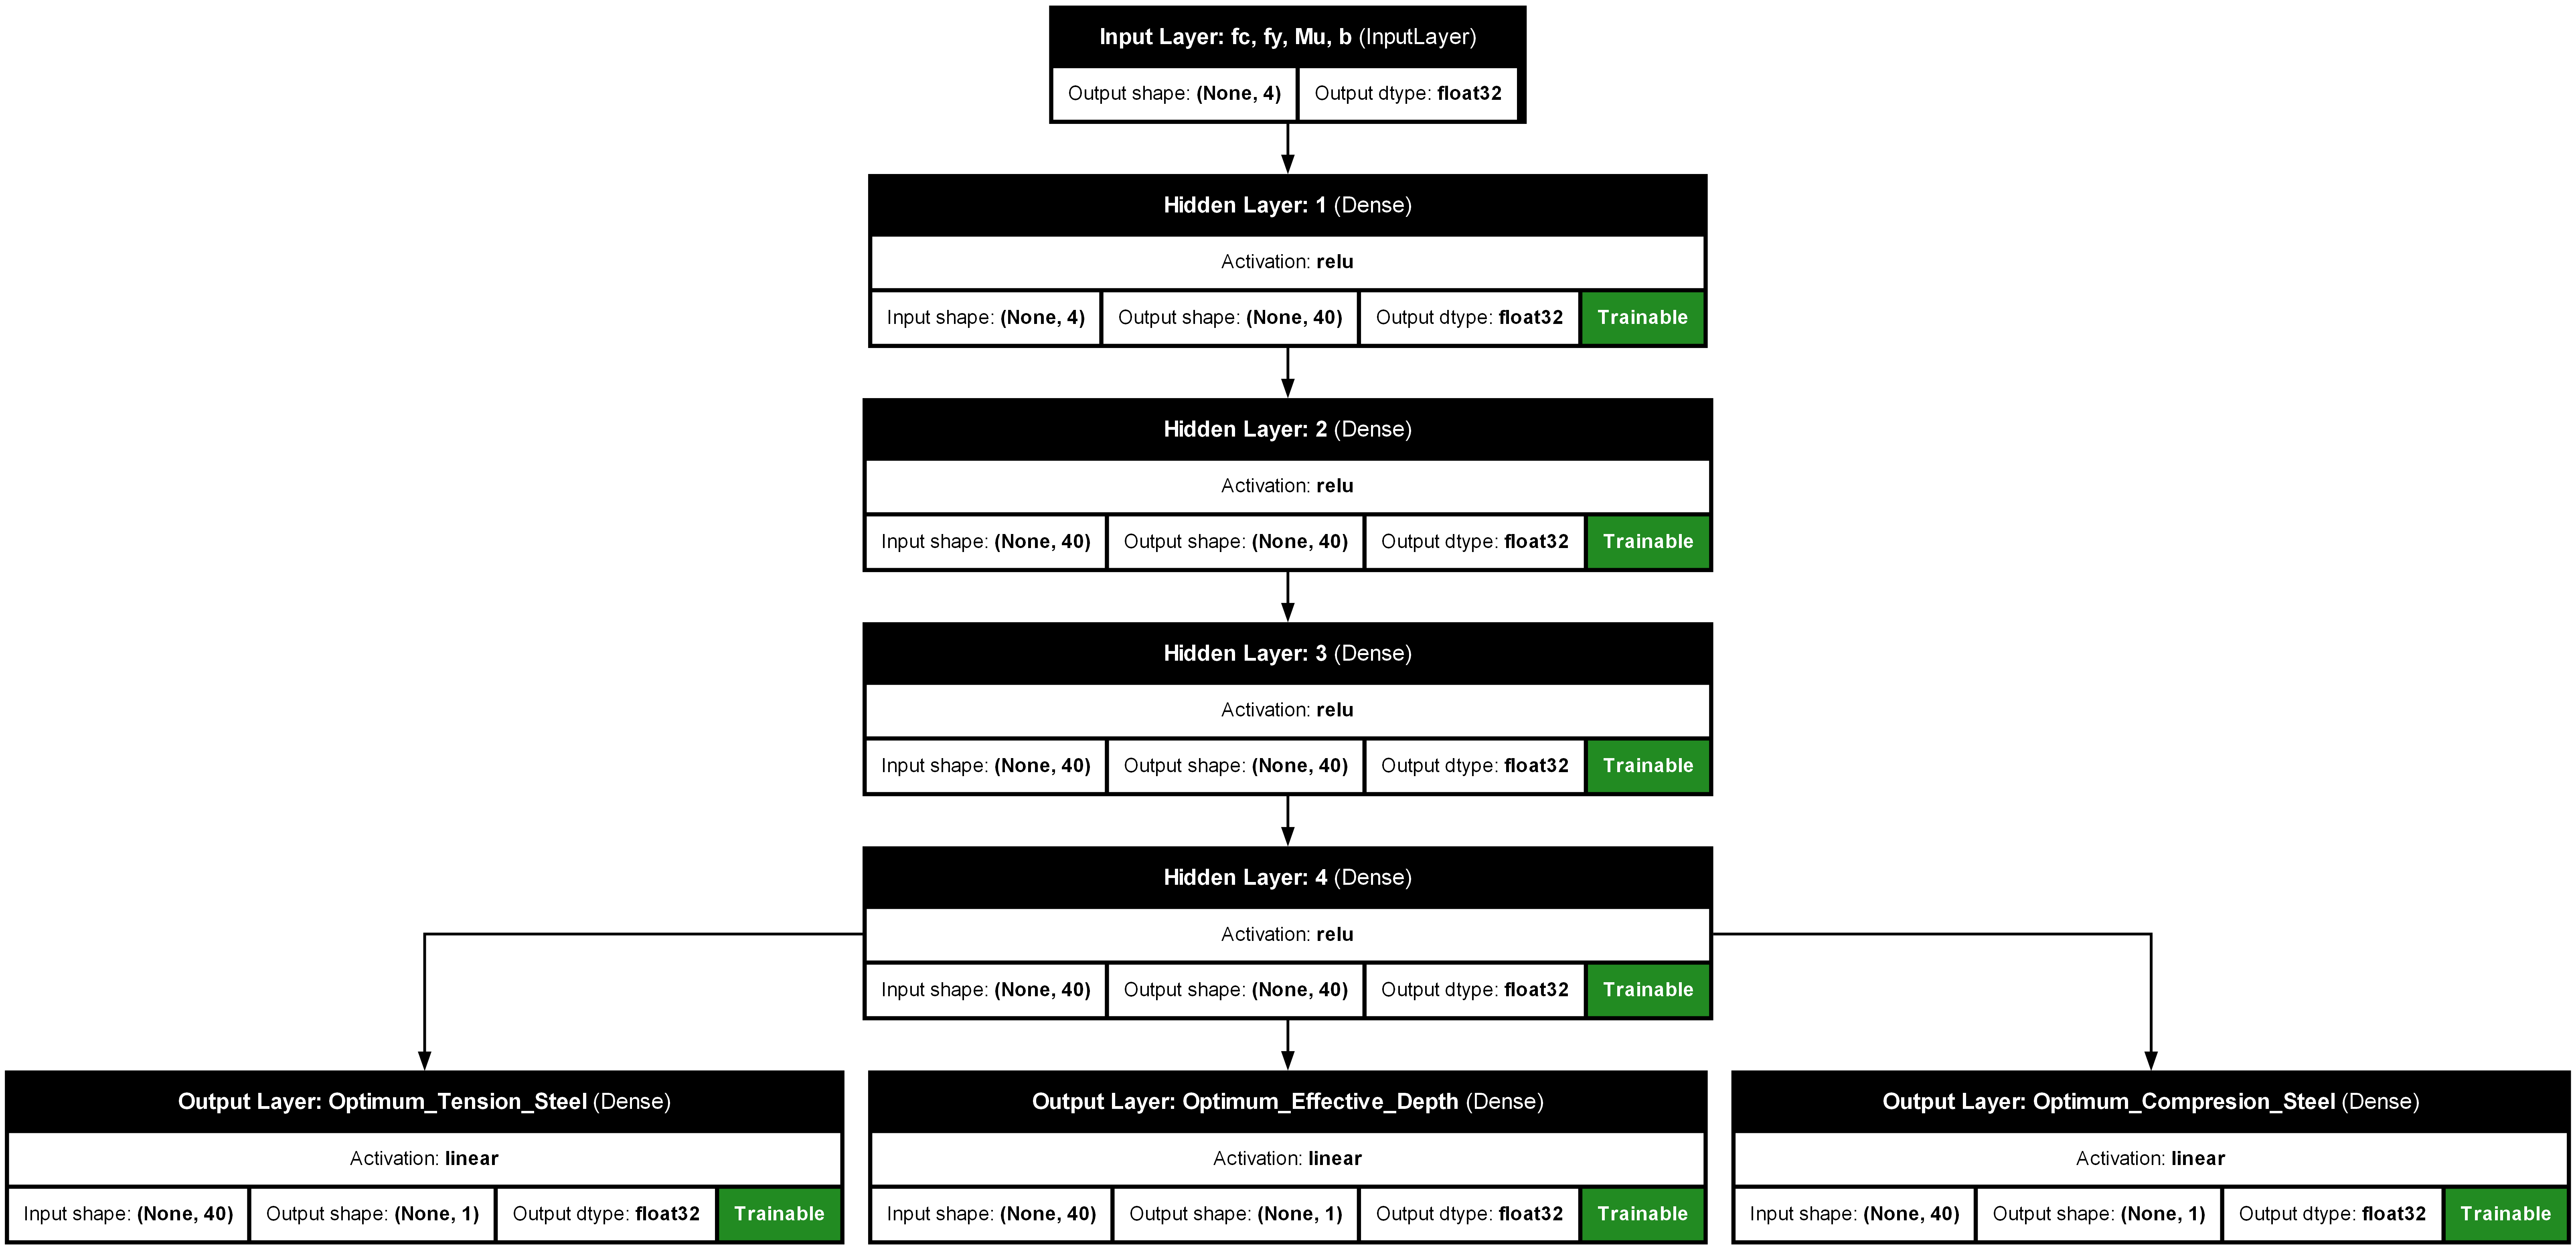

In [ ]:
#Model Plot in USE
# Define the layer names
layer_names = {
    "input_1": "Entrada",
    "dense": "Densa",
    "As_opt": "Optimum Tension Steel",
    "d_opt": "Optimum Effective Depth",
    "As_opt_p": "Optimum Compresion Steel"}

# Rename the layers in the model
for layer in mdl.layers:
    if layer.name in layer_names:
        layer.name = layer_names[layer.name]

# Plot the model
plot_model(mdl_scheme, to_file='model_architecture.png', show_shapes=True, show_layer_names=True, show_dtype=True, rankdir='TB',
           expand_nested=True, dpi=250, show_layer_activations=True, show_trainable=True)

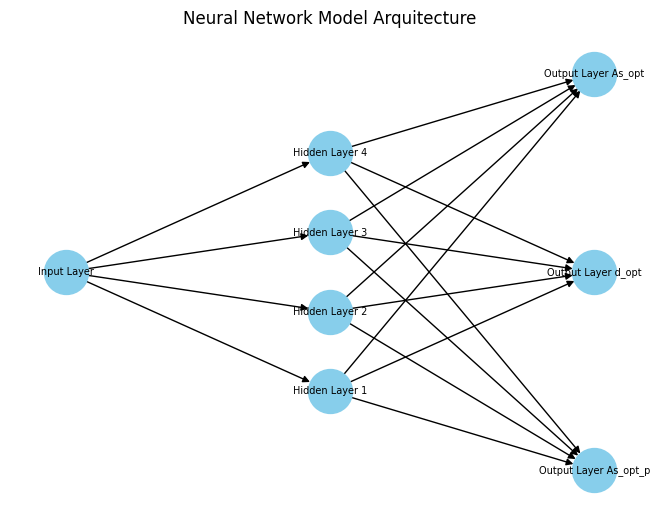

In [16]:
#Model Plot in USE
# Plotting the model graph
plot_model(mdl, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# NetworkX Graph
# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_node("Input Layer", pos=(0, 2.5))
for i in range(1, 5):
    G.add_node(f"Hidden Layer {i}", pos=(2.5, i))
G.add_node("Output Layer As_opt", pos=(5, 5))
G.add_node("Output Layer d_opt", pos=(5, 2.5))
G.add_node("Output Layer As_opt_p", pos=(5, 0))

# Add edges
for i in range(1, 5):
    G.add_edge("Input Layer", f"Hidden Layer {i}")
    G.add_edge(f"Hidden Layer {i}", "Output Layer As_opt")
    G.add_edge(f"Hidden Layer {i}", "Output Layer d_opt")
    G.add_edge(f"Hidden Layer {i}", "Output Layer As_opt_p")

# Get node positions
pos = nx.get_node_attributes(G, "pos")

# Draw the graph
nx.draw(G, pos, with_labels=True, node_size=1000, node_color="skyblue", font_size=7, font_color="black")
plt.title("Neural Network Model Arquitecture")
plt.show()

In [17]:
# Times the model will be trained
epochs = 5

In [18]:
total_epochs = 0

In [19]:
# Stats: Model 
mdl.summary()
print(mdl.weights)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input Layer: fc,    │ (None, 4)         │          0 │ -                 │
│ fy, Mu, b           │                   │            │                   │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Densa_1 (Dense)     │ (None, 40)        │        200 │ Input Layer: fc,  │
│                     │                   │            │ fy, Mu, b[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Densa_2 (Dense)     │ (None, 40)        │      1,640 │ Densa_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Densa_3 (Dense)     │ (None, 40)        │      1,640 │ Densa_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Densa_4 (Dense)     │ (None, 40)        │      1,640 │ Densa_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ As_opt (Dense)      │ (None, 1)         │         41 │ Densa_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_opt (Dense)       │ (None, 1)         │         41 │ Densa_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ As_opt_p (Dense)    │ (None, 1)         │         41 │ Densa_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,243 (20.48 KB)

 Trainable params: 5,243 (20.48 KB)

 Non-trainable params: 0 (0.00 B)

[<KerasVariable shape=(4, 40), dtype=float32, path=Densa_1/kernel>, <KerasVariable shape=(40,), dtype=float32, path=Densa_1/bias>, <KerasVariable shape=(40, 40), dtype=float32, path=Densa_2/kernel>, <KerasVariable shape=(40,), dtype=float32, path=Densa_2/bias>, <KerasVariable shape=(40, 40), dtype=float32, path=Densa_3/kernel>, <KerasVariable shape=(40,), dtype=float32, path=Densa_3/bias>, <KerasVariable shape=(40, 40), dtype=float32, path=Densa_4/kernel>, <KerasVariable shape=(40,), dtype=float32, path=Densa_4/bias>, <KerasVariable shape=(40, 1), dtype=float32, path=As_opt/kernel>, <KerasVariable shape=(1,), dtype=float32, path=As_opt/bias>, <KerasVariable shape=(40, 1), dtype=float32, path=d_opt/kernel>, <KerasVariable shape=(1,), dtype=float32, path=d_opt/bias>, <KerasVariable shape=(40, 1), dtype=float32, path=As_opt_p/kernel>, <KerasVariable shape=(1,), dtype=float32, path=As_opt_p/bias>]


In [20]:
# Model Conpiling
mdl.compile(optimizer='adam', loss=rmse ,metrics={'As_opt': 'accuracy', 'd_opt': 'accuracy', 'As_opt_p': 'accuracy'})

In [24]:
# Model Parameters Training 
mdl_fit = mdl.fit(xtrain, {"As_opt": ytrain1, "d_opt": ytrain2, "As_opt_p": ytrain3},
    epochs=epochs,
    verbose=True, 
    validation_split=0.05,
    callbacks=[checkpoint, tensorboard_callback])
total_epochs += epochs
total_epochs

Epoch 1/5
6649/6649 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - As_opt_accuracy: 0.0000e+00 - As_opt_p_accuracy: 0.0000e+00 - d_opt_accuracy: 0.0000e+00 - loss: 0.8001 - val_As_opt_accuracy: 0.0000e+00 - val_As_opt_p_accuracy: 0.0000e+00 - val_d_opt_accuracy: 0.0000e+00 - val_loss: 0.8613
Epoch 2/5
6649/6649 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - As_opt_accuracy: 0.0000e+00 - As_opt_p_accuracy: 0.0000e+00 - d_opt_accuracy: 0.0000e+00 - loss: 0.7114 - val_As_opt_accuracy: 0.0000e+00 - val_As_opt_p_accuracy: 0.0000e+00 - val_d_opt_accuracy: 0.0000e+00 - val_loss: 0.4483
Epoch 3/5
6649/6649 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - As_opt_accuracy: 0.0000e+00 - As_opt_p_accuracy: 0.0000e+00 - d_opt_accuracy: 0.0000e+00 - loss: 0.6536 - val_As_opt_accuracy: 0.0000e+00 - val_As_opt_p_accuracy: 0.0000e+00 - val_d_opt_accuracy: 0.0000e+00 - val_loss: 0.7974
Epoch 4/5
6649/6649 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - As_opt_accuracy: 0.0000e+00 - As_opt_p_accuracy: 0.0000e+00 - d_opt_accuracy: 0.0000e+00 - loss: 0

10

In [ ]:
# Load the TensorBoard notebook extension http://localhost:6006/
%load_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 15192), started 0:45:11 ago. (Use '!kill 15192' to kill it.)

In [ ]:
# Stats: Model Parameters Training
print(mdl_fit.history)

{'As_opt_accuracy': [0.0, 0.0, 0.0, 0.0, 0.0], 'As_opt_p_accuracy': [0.0, 0.0, 0.0, 0.0, 0.0], 'd_opt_accuracy': [0.0, 0.0, 0.0, 0.0, 0.0], 'loss': [2.165628671646118, 1.2729461193084717, 1.101991891860962, 0.9628224968910217, 0.8103805780410767], 'val_As_opt_accuracy': [0.0, 0.0, 0.0, 0.0, 0.0], 'val_As_opt_p_accuracy': [0.0, 0.0, 0.0, 0.0, 0.0], 'val_d_opt_accuracy': [0.0, 0.0, 0.0, 0.0, 0.0], 'val_loss': [1.2537215948104858, 1.2304409742355347, 0.8786101937294006, 0.851830780506134, 1.0665308237075806]}


6999/6999 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


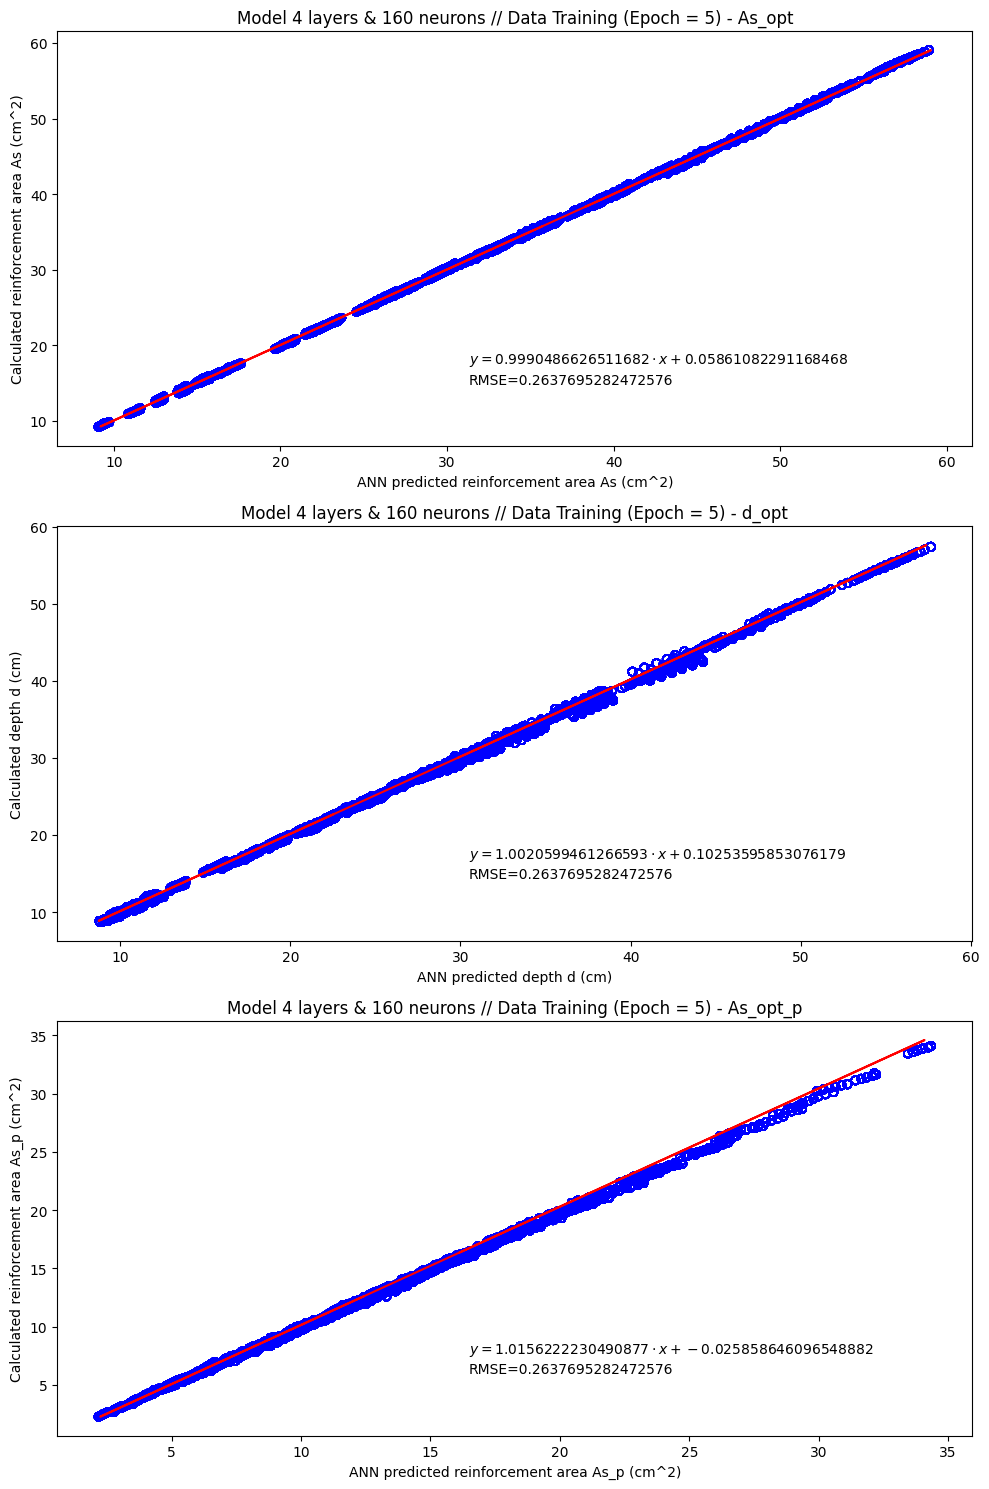

In [22]:
# COMPARING PREDICTED VALUES VS THEORETICAL VALUES
predictions = mdl.predict(xtrain)

# Las predicciones serán una lista de arrays, uno por cada salida
ypred1 = predictions[0].flatten()  # Predicciones para As_opt
ypred2 = predictions[1].flatten()  # Predicciones para d_opt
ypred3 = predictions[2].flatten()  # Predicciones para As_opt_p

def rmse(ytrue,ypred):
  return tf.sqrt(tf.reduce_mean(tf.square(ytrue - ypred)))

RMSE=rmse(ytrain1,ypred1)
RMSE=rmse(ytrain2,ypred2)
RMSE=rmse(ytrain3,ypred3)

# Coefficients
m1, b1 = np.polyfit(ytrain1, ypred1, 1)
m2, b2 = np.polyfit(ytrain2, ypred2, 1)
m3, b3 = np.polyfit(ytrain3, ypred3, 1)

# Crear subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Lista de etiquetas y predicciones
etiquetas = [ytrain1, ytrain2, ytrain3]
predicciones = [ypred1, ypred2, ypred3]
ms = [m1, m2, m3]
bs = [b1, b2, b3]


# Títulos de los gráficos
titulos = [
    f'Model {total_layers} layers & {total_neurons} neurons // Data Training (Epoch = {total_epochs}) - As_opt',
    f'Model {total_layers} layers & {total_neurons} neurons // Data Training (Epoch = {total_epochs}) - d_opt',
    f'Model {total_layers} layers & {total_neurons} neurons // Data Training (Epoch = {total_epochs}) - As_opt_p'
]

# Etiquetas de los ejes y
etiquetas_y = [
    'Calculated reinforcement area As (cm^2)',
    'Calculated depth d (cm)',
    'Calculated reinforcement area As_p (cm^2)'
]

# Etiquetas de los ejes x
etiquetas_x = [
    'ANN predicted reinforcement area As (cm^2)',
    'ANN predicted depth d (cm)',
    'ANN predicted reinforcement area As_p (cm^2)'
]

# Iterar sobre cada subplot
for i, (etiqueta, prediccion, m, b, titulo) in enumerate(zip(etiquetas, predicciones, ms, bs, titulos)):
    # Gráfico scatter
    axs[i].scatter(prediccion, etiqueta, facecolors='none', edgecolors='b')
    axs[i].plot(etiqueta, m * etiqueta + b, color='red')
    axs[i].text(0.45, 0.2, f'$y = {m} \\cdot x + {b}$', fontsize=10, transform=axs[i].transAxes)
    axs[i].text(0.45, 0.15, f'RMSE={RMSE}', fontsize=10, transform=axs[i].transAxes)
    axs[i].set_xlabel(etiquetas_x[i])
    axs[i].set_ylabel(etiquetas_y[i])
    axs[i].set_title(titulo)

# Ajustar diseño de subplots
plt.tight_layout()
plt.show()

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


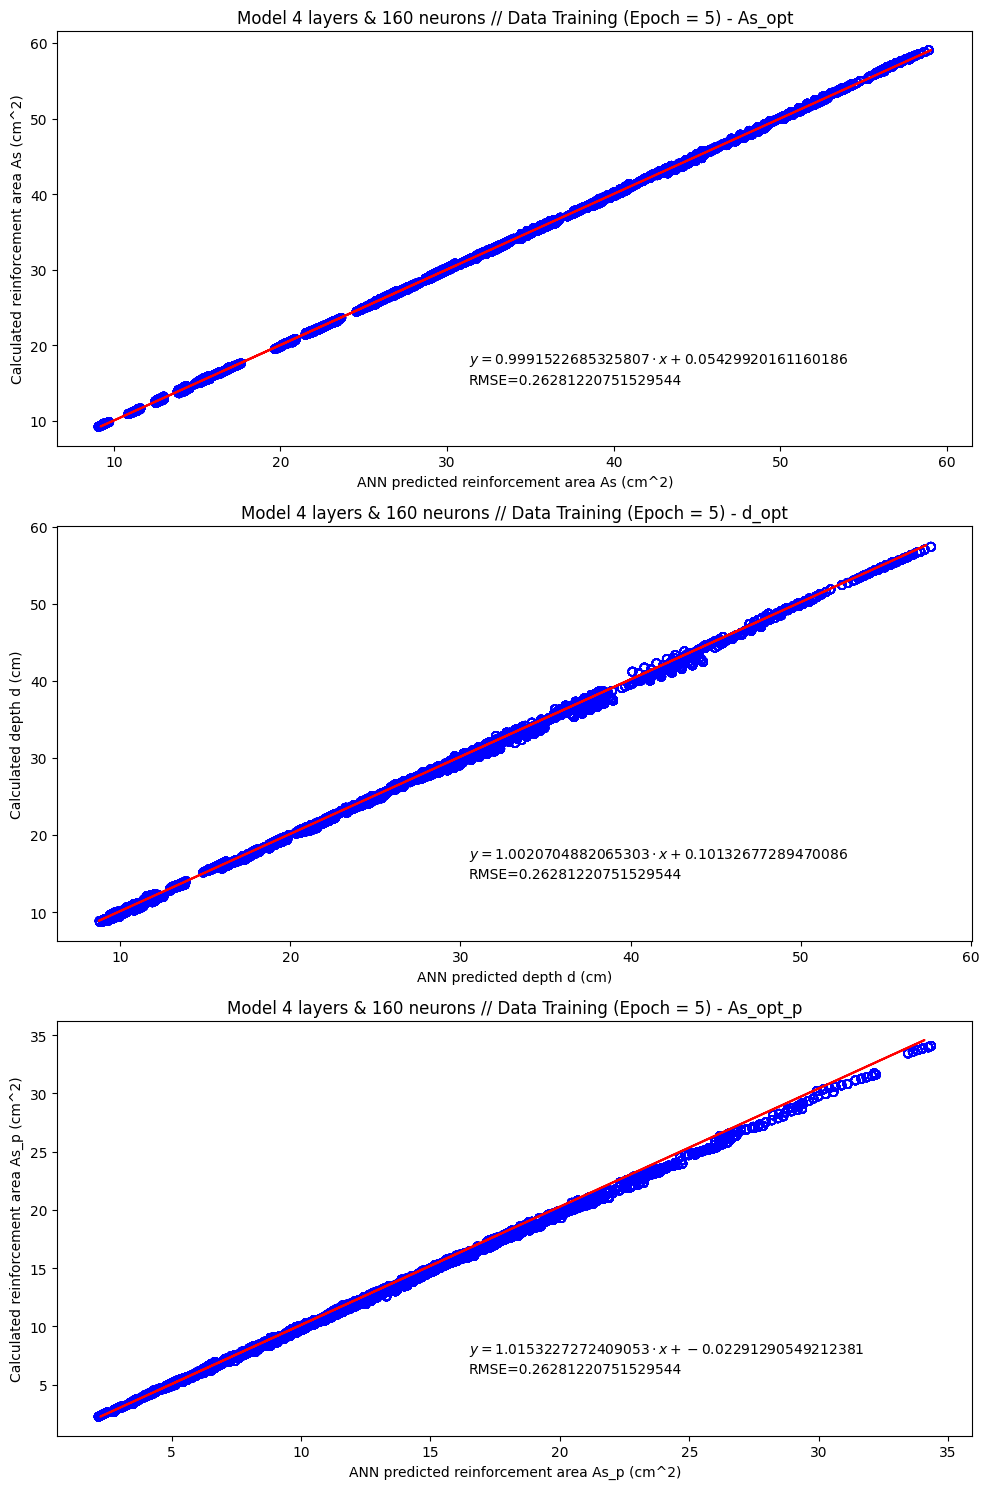

In [23]:
# COMPARING PREDICTED VALUES VS THEORETICAL VALUES
testing = mdl.predict(xtest)

# Las predicciones serán una lista de arrays, uno por cada salida
ypred1 = testing[0].flatten()  # Predicciones para As_opt
ypred2 = testing[1].flatten()  # Predicciones para d_opt
ypred3 = testing[2].flatten()  # Predicciones para As_opt_p

def rmse(ytrue,ypred):
  return tf.sqrt(tf.reduce_mean(tf.square(ytrue - ypred)))

RMSE=rmse(ytest1,ypred1)
RMSE=rmse(ytest2,ypred2)
RMSE=rmse(ytest3,ypred3)

# Coefficients
m1, b1 = np.polyfit(ytest1, ypred1, 1)
m2, b2 = np.polyfit(ytest2, ypred2, 1)
m3, b3 = np.polyfit(ytest3, ypred3, 1)

# Crear subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Lista de etiquetas y predicciones
etiquetas = [ytest1, ytest2, ytest3]
predicciones = [ypred1, ypred2, ypred3]
ms = [m1, m2, m3]
bs = [b1, b2, b3]

# Títulos de los gráficos
titulos = [
    f'Model {total_layers} layers & {total_neurons} neurons // Data Training (Epoch = {total_epochs}) - As_opt',
    f'Model {total_layers} layers & {total_neurons} neurons // Data Training (Epoch = {total_epochs}) - d_opt',
    f'Model {total_layers} layers & {total_neurons} neurons // Data Training (Epoch = {total_epochs}) - As_opt_p']

# Etiquetas de los ejes y
etiquetas_y = [
    'Calculated reinforcement area As (cm^2)',
    'Calculated depth d (cm)',
    'Calculated reinforcement area As_p (cm^2)']

# Etiquetas de los ejes x
etiquetas_x = [
    'ANN predicted reinforcement area As (cm^2)',
    'ANN predicted depth d (cm)',
    'ANN predicted reinforcement area As_p (cm^2)']

# Iterar sobre cada subplot
for i, (etiqueta, prediccion, m, b, titulo) in enumerate(zip(etiquetas, predicciones, ms, bs, titulos)):
    # Gráfico scatter
    axs[i].scatter(prediccion, etiqueta, facecolors='none', edgecolors='b')
    axs[i].plot(etiqueta, m * etiqueta + b, color='red')
    axs[i].text(0.45, 0.2, f'$y = {m} \\cdot x + {b}$', fontsize=10, transform=axs[i].transAxes)
    axs[i].text(0.45, 0.15, f'RMSE={RMSE}', fontsize=10, transform=axs[i].transAxes)
    axs[i].set_xlabel(etiquetas_x[i])
    axs[i].set_ylabel(etiquetas_y[i])
    axs[i].set_title(titulo)

# Ajustar diseño de subplots
plt.tight_layout()
plt.show()

In [2]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))
from tensorflow.keras.models import load_model; import pandas as pd, numpy as np
mdl = load_model(r'D:\ToolBox\.py\rep_1\models\mdl_checkpoint_bms_1.0.keras', custom_objects={'rmse': rmse})

In [3]:
db=pd.read_excel(r'D:\ToolBox\.py\rep_1\data\processed\db_2.0.xlsx')
# Datos de ETABS
data_Etabs = pd.DataFrame({'fc': [21], 'fy': [410], 'Mu': [200], 'b': [300]})

# Evaluación en el modelo entrenado por ANN y convertir las predicciones a valores escalares
a, b, c = [pred[0][0] for pred in mdl.predict(data_Etabs)]

# Calcula la distancia euclidiana y obtiene el índice de la fila con la menor distancia
indice_min = np.argmin(np.sqrt((db['As_opt'] - a)**2 + (db['d_opt'] - b)**2 + (db['As_opt_p'] - c)**2))

# Imprime las ternas correspondientes a la fila con la menor distancia
print(f"Terna de modelado:\n* As+: {a} cm^2\n* d: {b}\n* As-: {c}")
print(f"\nTerna analítica:\n* As+: {db['As_opt'][indice_min]} cm^2\n* d: {db['d_opt'][indice_min]}\n* As-: {db['As_opt_p'][indice_min]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Terna de modelado:
* As+: 23.500089645385742 cm^2
* d: 23.609601974487305
* As-: 13.027591705322266

Terna analítica:
* As+: 23.61737327567097 cm^2
* d: 20.74718120077748
* As-: 13.37732703138482
